# 🔧 Imports and Setup

In [1]:
!pip install -U --q pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.3 MB/s eta 0:00:00


In [2]:
# Data
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import matplotlib.gridspec as gridspec

# Statistical
from scipy import stats
import holidays
import pycountry

# Preprocessing and Modeling
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

# LightGBM
import lightgbm as lgb

# Other
import datetime
import warnings
warnings.filterwarnings('ignore')

# Global Config
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
color_palette = sns.color_palette(['#D62728', '#9467BD', '#8C564B', '#1F77B4', '#FF7F0E', '#2CA02C'])
np.random.seed(42)

# Config variables
SEED = 42
n_splits = 5
n_estimators = 1000
early_stopping_rounds = 100
FE_holidays = True


### Load: train and test

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv", index_col = "id")
test = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv", index_col = "id")

print("shape: train, test\n", train.shape,test.shape)
display(train.tail())

shape: train, test
 (230130, 5) (98550, 4)


,date,country,store,product,num_sold
id,,,,,
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0
230129,2016-12-31,Singapore,Premium Sticker Mart,Kerneler Dark Mode,1622.0


### Concat (X)_train and test

In [4]:
train.dropna(subset=["num_sold"], inplace=True)
X = train.copy()
y = X.pop("num_sold")

full = pd.concat([X,test], axis = 0)

In [5]:
print("Missing:\n Target")
display(train["num_sold"].isnull().sum())

print("y: ")
y.isnull().sum()


Missing:
 Target


0

y: 


0

### Duplicates ?

In [6]:
train.duplicated().sum(),test.duplicated().sum()

(0, 0)

# >> 📊 Exploratory Data Analysis

In [7]:
print("train. \n info: \n",train.info())
print("\ndescriptive statistics: \n",train.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 221259 entries, 1 to 230129
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      221259 non-null  object 
 1   country   221259 non-null  object 
 2   store     221259 non-null  object 
 3   product   221259 non-null  object 
 4   num_sold  221259 non-null  float64
dtypes: float64(1), object(4)
memory usage: 10.1+ MB
train. 
 info: 
 None

descriptive statistics: 
             num_sold
count  221259.000000
mean      752.527382
std       690.165445
min         5.000000
25%       219.000000
50%       605.000000
75%      1114.000000
max      5939.000000


# 🔎 Missing

In [8]:
print("y missing : ")
print("%: ",y.isnull().mean())
print("sum: ", y.isnull().sum())

def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(full)

# Missing Matrix ...
# msno.matrix(full)

y missing : 
%:  0.0
sum:  0


,Total,Percent


# 🎯 Target

We can see that "num_sold" is right skewed. Therefore we can try to transform our target to see if we transform it to a (more) normal distribution. To do this we apply a log transformation.

train.num_sold.median() :  605.0
train.num_sold.mean() :  752.527381937006
train.num_sold.max() :  5939.0


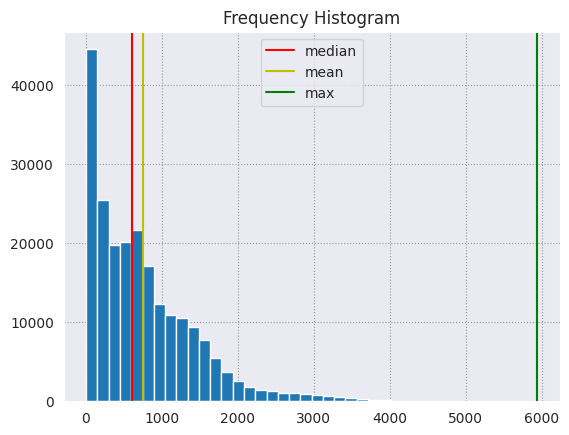

In [9]:
print("train.num_sold.median() : ", train.num_sold.median())
print("train.num_sold.mean() : ", train.num_sold.mean())
print("train.num_sold.max() : ", train.num_sold.max())

train.num_sold.hist(bins = 40)
plt.title("Frequency Histogram")
plt.axvline(train.num_sold.median(), label = "median", color = "r")
plt.axvline(train.num_sold.mean(), label = "mean", color = "y")
plt.axvline(train.num_sold.max(), label = "max", color = "g")
plt.legend()

 with a log1np transformation ...



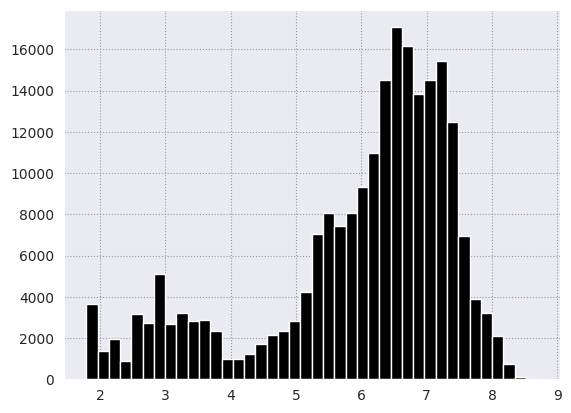

In [10]:
print(" with a log1np transformation ...\n")
# train.num_sold.hist(bins = 40)
plt.hist(np.log1p(train.num_sold), bins = 40, color = "black")
plt.show()

### Confirming Hypotheses... Analyzing Normality in Depth.
  
Understanding the normality of the target or features is crucial because many statistical and machine learning models assume a normal distribution. By confirming skewness and analyzing the distribution in detail, we can decide whether transformations are needed to improve model performance or interpretability.

----

- **Right skew**: Tail toward high values, transformation like `log(x)`.
- **Left skew**: Tail toward low values, transformation like `x^2`.


Skewness: 1.42
Kurtosis: 2.61


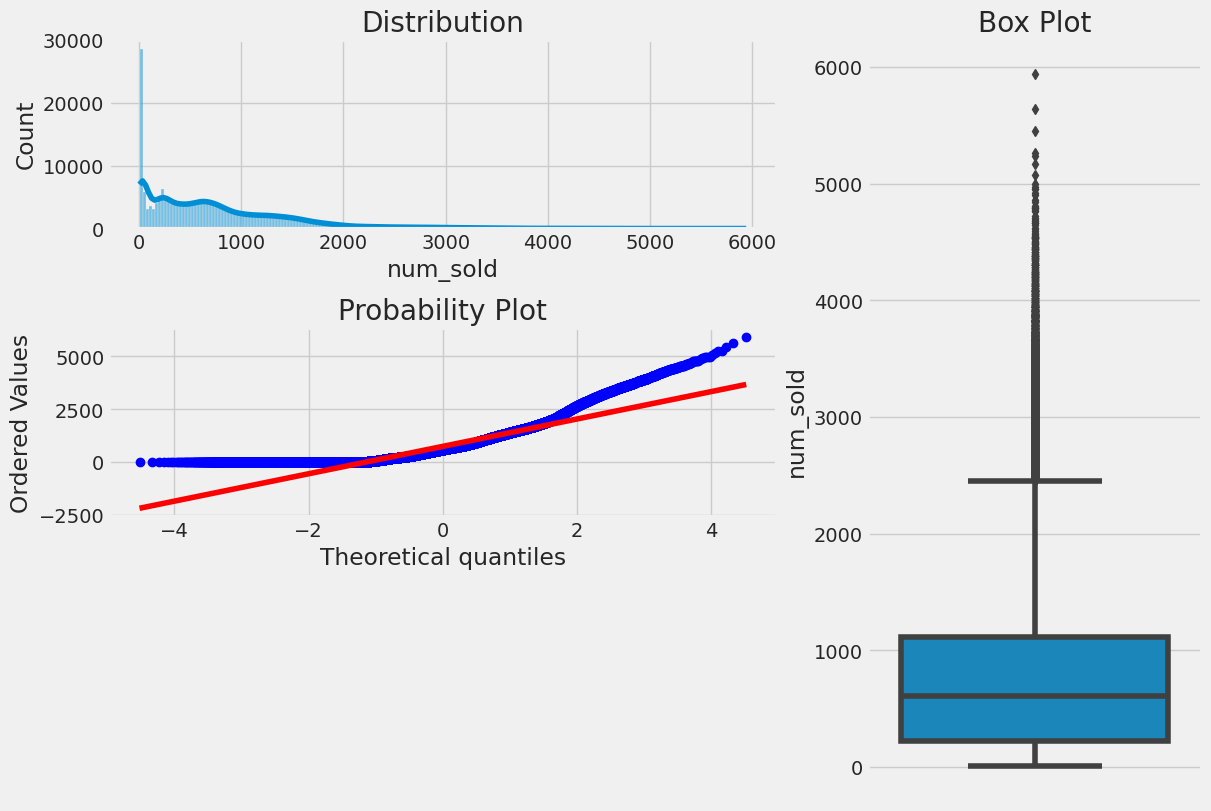

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
import warnings

warnings.filterwarnings("ignore")

def plotting_3_chart(df, feature):
    # Ensure matplotlib style is set correctly
    style.use('fivethirtyeight')
    
    # Drop missing values
    df = df.dropna(subset=[feature])
    
    # Create a figure with constrained layout
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    # Create a grid layout
    grid = GridSpec(ncols=3, nrows=3, figure=fig)

    # Histogram plot
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Distribution')
    sns.histplot(df[feature], kde=True, ax=ax1)  # Updated from sns.distplot to sns.histplot

    # QQ plot
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ Plot')
    stats.probplot(df[feature], plot=ax2)

    # Box plot
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(y=df[feature], ax=ax3)  # Adjusted for modern Seaborn usage

    # Display skewness and kurtosis
    print("Skewness: {:.2f}".format(df[feature].skew()))
    print("Kurtosis: {:.2f}".format(df[feature].kurt()))
    
    # Show the plots
    plt.show()


plotting_3_chart(train, 'num_sold')


----

# 🔠 Categorical features: Statistical analysis

ANOVA:

https://en.wikipedia.org/wiki/Analysis_of_variance

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Example_of_ANOVA_table.jpg/380px-Example_of_ANOVA_table.jpg)

Kruskal-Wallis: 

https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test

![img](https://wikimedia.org/api/rest_v1/media/math/render/svg/3999eb7c5d7b3e0bbbd6eedfe37db5efb44deceb)

The goal is the check if there is a statistical significant relationship between the categories and the target 'num_sold'. A way we can do this is by using a one-way ANOVA test or the Kruskal-Wallis H-test. The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. Because the ANOVA has some underlying assumptions we use both to check for a statistical significant relaton between the categorical features and the target. See the Scipy documentation for more information on both tests [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html) and [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html). 

In [12]:
from scipy.stats import f_oneway, kruskal
import pandas as pd

def cat_kruskal(train_df: pd.DataFrame, target: str, to_drop: str = None) -> pd.DataFrame:
    """
    Perform ANOVA and Kruskal-Wallis tests on categorical features in the DataFrame.
    
    Parameters:
        train_df (pd.DataFrame): The training DataFrame.
        target (str): The target column name.
        to_drop (str): The column to exclude from the analysis, if any.

    Returns:
        pd.DataFrame: A DataFrame with test statistics and p-values.
    """
    test_cat_list = []
    test_cat_cols = []
    
    # Select categorical columns
    cat_cols = train_df.select_dtypes(include=['object', 'category']).columns
    
    # Drop the specified column if to_drop is not None
    if to_drop is not None:
        cat_cols = cat_cols.drop(to_drop)
    
    for col in cat_cols:
        # Group target values by the categorical feature
        test_group = train_df.groupby(col)[target].apply(list)
        
        # Perform ANOVA and Kruskal-Wallis tests
        f_oneway_result = f_oneway(*test_group)
        kruskal_result = kruskal(*test_group)
    
        # Store results
        test_cat_list.append(
            [f_oneway_result.statistic, f_oneway_result.pvalue, kruskal_result.statistic, kruskal_result.pvalue]
        )
        test_cat_cols.append(col)
    
    # Return results as a DataFrame
    return pd.DataFrame(
        test_cat_list,
        index=test_cat_cols,
        columns=['anova_statistic', 'anova_pvalue', 'kruskal_statistic', 'kruskal_pvalue']
    )

# Example usage
cat_kruskal(train_df = train, target = 'num_sold', to_drop='date')


,anova_statistic,anova_pvalue,kruskal_statistic,kruskal_pvalue
country,24669.224785,0.0,104239.892502,0.0
store,13971.768812,0.0,22530.330040,0.0
product,19576.262467,0.0,59646.551041,0.0


Based on the statistical models applied, we can confirm the presence of statistical significance in the study of our categorical variables. The ANOVA and Kruskal-Wallis tests for variables like `country`, `store`, and `product` show extremely low p-values, indicating that the differences observed in the target variable across these categories are highly significant.

These findings demonstrate that the relationships between the target and the categorical variables are statistically meaningful.

## 🛠️ Plot all features - Visualizing: stickers sales

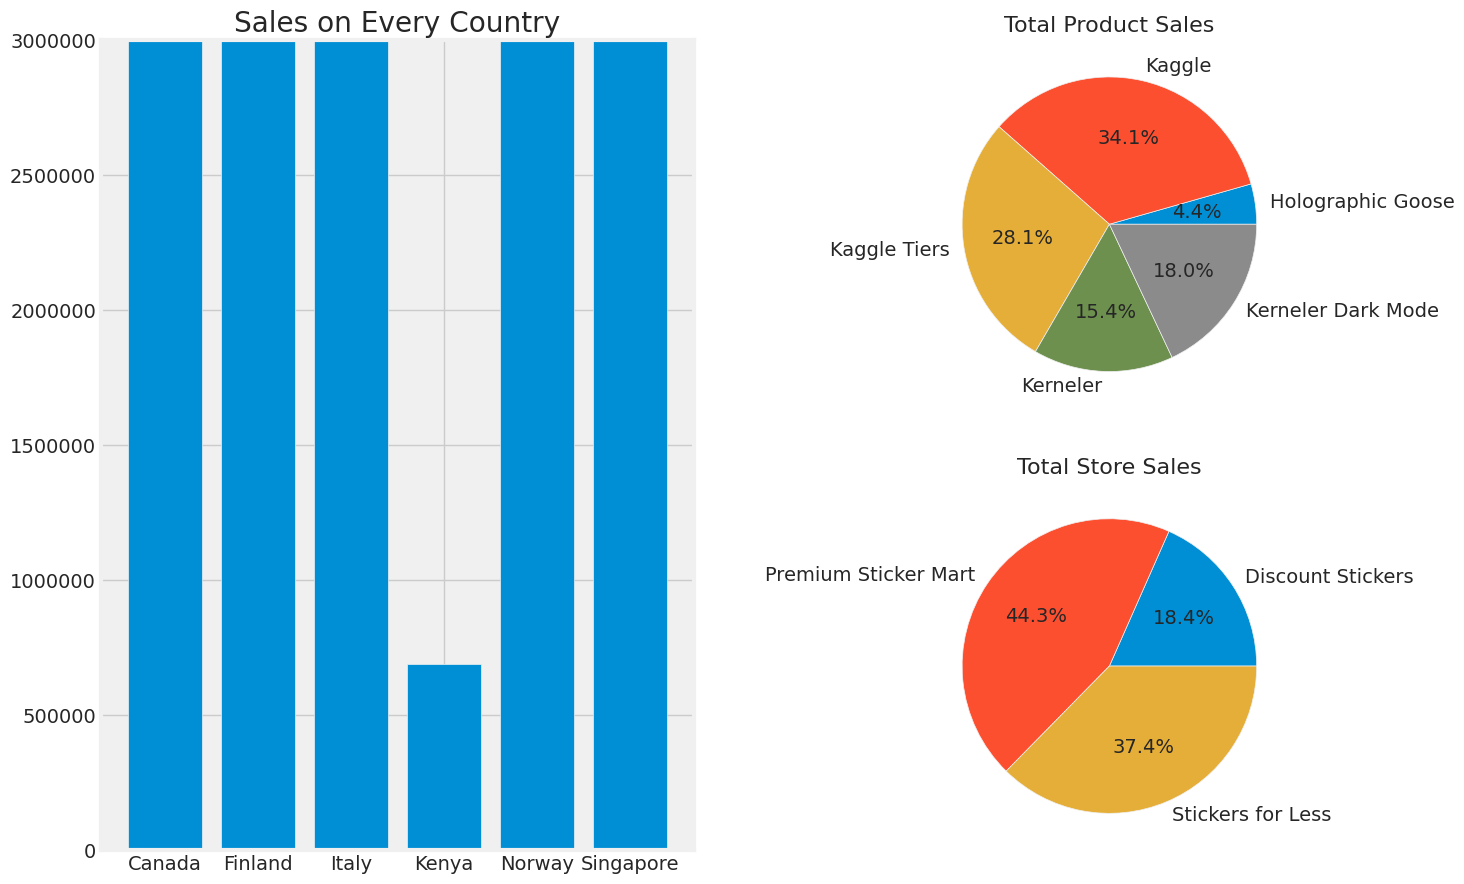

In [13]:


sold_product = train.groupby(['product'])['num_sold'].sum()
sold_store = train.groupby(['store'])['num_sold'].sum()
sold_country = train.groupby(['country'])['num_sold'].sum()

fig = plt.figure(figsize=(15,10))
fig.set_facecolor('white')

ax1 = fig.add_subplot(1, 2, 1)
ax1.bar(sold_country.keys(), sold_country.values)
ax1.set_title('Sales on Every Country')
ax1.ticklabel_format(style='plain', axis='y')
ax1.set_ylim(0, 3e6)

ax2 = fig.add_subplot(2, 2, 2)
ax2.pie(sold_product.values, labels=sold_product.keys(), autopct="%.1f%%")
ax2.set_title('Total Product Sales', fontsize=16)

ax3 = fig.add_subplot(2, 2, 4)
ax3.pie(sold_store.values, labels=sold_store.keys(), autopct="%.1f%%")
ax3.set_title('Total Store Sales', fontsize=16);

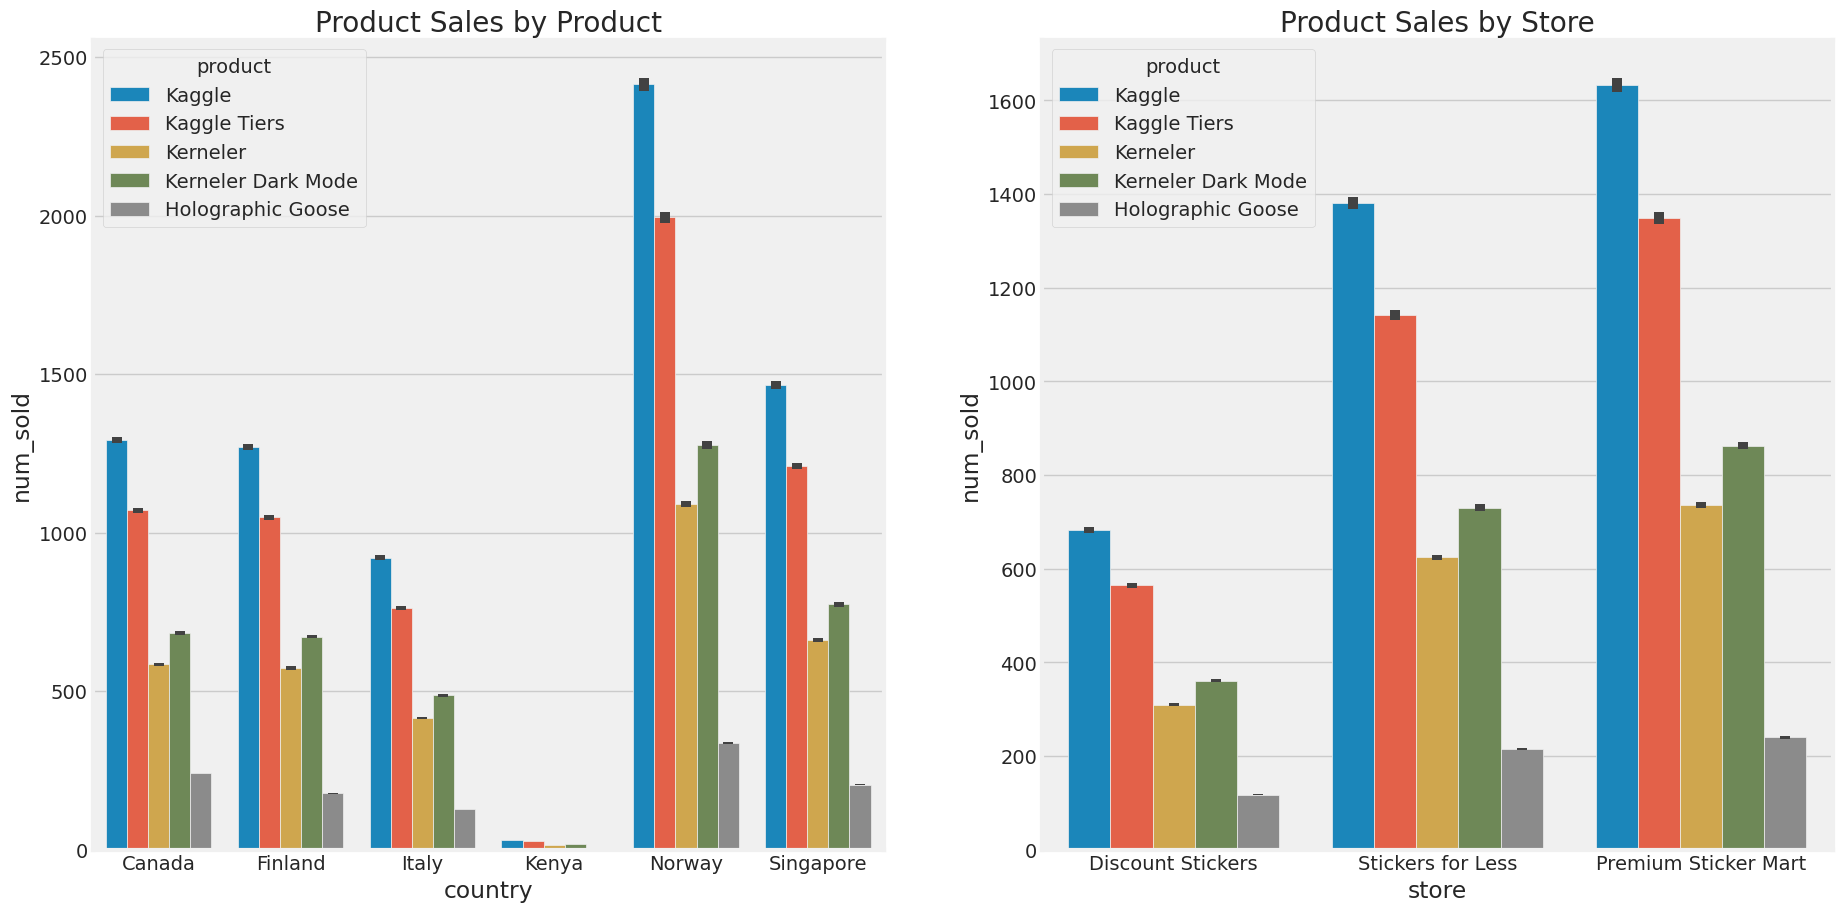

In [14]:

fig = plt.figure(figsize=(20,10))
fig.set_facecolor('white')

ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(data=train, x='country', y='num_sold', hue='product')
ax1.set_title('Product Sales by Product')

ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(data=train, x='store', y='num_sold', hue='product')
ax2.set_title("Product Sales by Store");

# >> ⏳ Preprocessing 


## 💡 Macroeconomic Data:


<img src="https://www.investopedia.com/thmb/r3__AYNr_PxJoFEeDp-2rr3SvDc=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/economic_indicator.aspfinal-15940724deaf40e09bf27f9e6b0bf832.jpg" width="750"/>

Incorporating GDP and other macroeconomic data provides valuable context about the broader economic environment. These variables influence consumer behavior, spending patterns, and market dynamics, which can significantly impact the target variable. Including them helps models account for external factors, improving prediction accuracy and capturing trends tied to economic conditions.

Economic data is a key indicator of a country's economic health and performance. World Bank, provides research, statistics, and information on future prospects.

---

**Indicators Related to Consumption and the Economy:**

key indicators: 'Population': 'SP.POP.TOTL' and "GDP or in my lenguage (spanish): PBI"

**Final Consumption Expenditure**  
- **Indicator**: NE.CON.TOTL.ZS  
- **Description**: Total consumption expenditure as a percentage of GDP.


**Exports and Imports as Percentage of GDP**  
- **Indicators**: NE.EXP.GNFS.ZS (Exports), NE.IMP.GNFS.ZS (Imports)  
- **Description**: Measures the share of exports and imports in GDP, which can influence consumption and trade balance.


**Unemployment Rate**  
- **Indicator**: SL.UEM.TOTL.ZS  
- **Description**: Total unemployment as a percentage of the active population, signaling labor market health and potential economic stress.


In [15]:

import requests

# Function to fetch GDP per capita
def get_gdp_per_capita(country, year):
    alpha3 = {
        'Canada': 'CAN', 'Finland': 'FIN', 'Italy': 'ITA',
        'Kenya': 'KEN', 'Norway': 'NOR', 'Singapore': 'SGP'
    }
    url = f"https://api.worldbank.org/v2/country/{alpha3[country]}/indicator/NY.GDP.PCAP.CD?date={year}&format=json"
    response = requests.get(url).json()
    try:
        return response[1][0]['value']
    except (IndexError, TypeError):
        return None

countries = ['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore']
years = range(2010, 2020)
gdp_data = {}

for country in countries:
    for year in years:
        gdp_data[(country, year)] = get_gdp_per_capita(country, year)

# Add GDP feature to train and test DataFrames
def add_gdp_feature(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year  # Extract year from the date
    df['gdp'] = df.apply(lambda row: gdp_data.get((row['country'], row['year']), None), axis=1)
    return df

add_gdp_feature(full)
full.tail()

,date,country,store,product,year,gdp
id,,,,,,
328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose,2019,66081.719924
328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle,2019,66081.719924
328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2019,66081.719924
328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler,2019,66081.719924
328679,2019-12-31,Singapore,Premium Sticker Mart,Kerneler Dark Mode,2019,66081.719924


In [16]:

def get_indicator_data(country, year, indicator_code):
    alpha3 = {
        'Canada': 'CAN', 'Finland': 'FIN', 'Italy': 'ITA',
        'Kenya': 'KEN', 'Norway': 'NOR', 'Singapore': 'SGP'
    }
    url = f"https://api.worldbank.org/v2/country/{alpha3[country]}/indicator/{indicator_code}?date={year}&format=json"
    response = requests.get(url).json()
    try:
        return response[1][0]['value']
    except (IndexError, TypeError):
        return None

# Indicator codes
indicators = {
    'Final Consumption Expenditure': 'NE.CON.TOTL.ZS',
    # 'Household and Business Savings': 'NY.GDP.PCAP.CD', # similar to gdp
    'Exports as Percentage of GDP': 'NE.EXP.GNFS.ZS',
    'Imports as Percentage of GDP': 'NE.IMP.GNFS.ZS',
    #'Poverty Rate': 'SI.POV.Dday', # Incomplete data
    'Unemployment Rate': 'SL.UEM.TOTL.ZS',
    'Population': 'SP.POP.TOTL',
    # 'Gross National Income Per Capita': 'NY.GDP.PCAP.CD' # similar to gdp
}

# List of countries and years
countries = ['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'] # this or: >>>  list(full.country.value_counts().index)
years = range(2010, 2020)

# Dictionary to store data for all indicators
indicator_data = {indicator: {} for indicator in indicators}

# Fetch the indicator data
for indicator, code in indicators.items():
    for country in countries:
        for year in years:
            indicator_data[indicator][(country, year)] = get_indicator_data(country, year, code)

# Function to add indicator features to the DataFrame
def add_indicator_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year  # Extract year from the date
    
    # Add each indicator as a new feature
    for indicator in indicators:
        df[indicator] = df.apply(lambda row: indicator_data[indicator].get((row['country'], row['year']), None), axis=1)
    
    return df

# :)
add_indicator_features(full)


,date,country,store,product,year,gdp,Final Consumption Expenditure,Exports as Percentage of GDP,Imports as Percentage of GDP,Unemployment Rate,Population
id,,,,,,,,,,,
1,2010-01-01,Canada,Discount Stickers,Kaggle,2010,47560.666601,78.473824,29.167382,31.040740,8.178,34005902
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,2010,47560.666601,78.473824,29.167382,31.040740,8.178,34005902
3,2010-01-01,Canada,Discount Stickers,Kerneler,2010,47560.666601,78.473824,29.167382,31.040740,8.178,34005902
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2010,47560.666601,78.473824,29.167382,31.040740,8.178,34005902
5,2010-01-01,Canada,Stickers for Less,Holographic Goose,2010,47560.666601,78.473824,29.167382,31.040740,8.178,34005902
...,...,...,...,...,...,...,...,...,...,...,...
328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose,2019,66081.719924,45.606720,176.300089,146.770341,3.100,5703569
328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle,2019,66081.719924,45.606720,176.300089,146.770341,3.100,5703569
328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2019,66081.719924,45.606720,176.300089,146.770341,3.100,5703569


# ⚙️ FE: trade balance as Percentage of GDP and more

Balance of trade (BOT) is the difference between the value of a country's imports and exports for a given period and is the largest component of a country's balance of payments (BOP).

![img](https://education.cfr.org/sites/default/files/images/photo/2024/07/trade_deficit_supporting_balances.cfrelogo.png)



### Details:
- **Exports as Percentage of GDP**: This is the value of exports of goods and services expressed as a percentage of GDP.
- **Imports as Percentage of GDP**: This is the value of imports of goods and services expressed as a percentage of GDP.
- The difference between these two metrics gives a direct measure of the trade balance as a percentage of GDP.

### Interpretation:
1. **Positive result**: This means that exports exceed imports, indicating a **trade surplus**.
2. **Negative result**: This means that imports exceed exports, indicating a **trade deficit**.
3. **Zero result**: Indicates balanced trade, where exports and imports are equal as a percentage of GDP.




In [17]:
full["BOT"]= full["Exports as Percentage of GDP"] - full["Imports as Percentage of GDP"]
full.drop(["Exports as Percentage of GDP", "Imports as Percentage of GDP"], axis = 1, inplace = True)

In [18]:
full.head()

,date,country,store,product,year,gdp,Final Consumption Expenditure,Unemployment Rate,Population,BOT
id,,,,,,,,,,
1,2010-01-01,Canada,Discount Stickers,Kaggle,2010,47560.666601,78.473824,8.178,34005902,-1.873358
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,2010,47560.666601,78.473824,8.178,34005902,-1.873358
3,2010-01-01,Canada,Discount Stickers,Kerneler,2010,47560.666601,78.473824,8.178,34005902,-1.873358
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2010,47560.666601,78.473824,8.178,34005902,-1.873358
5,2010-01-01,Canada,Stickers for Less,Holographic Goose,2010,47560.666601,78.473824,8.178,34005902,-1.873358


## 📅 Date breakdown

The sine and cosine transformations capture the cyclical nature of time features like day, month, and year, which repeat periodically. These transformations avoid misleading linear relationships and ensure the start and end of cycles (e.g., December to January) are represented smoothly. Sine handles the "ups and downs," while cosine complements it for a 2D representation. This approach normalizes values to \([-1, 1]\), avoids discontinuities, and improves model interpretability and predictive power, especially in regression and time-series problems.

In [19]:
def full_date_FE(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    df['month_country'] = df['month'].astype(str) + "_" + df['country']
    df['month_store'] = df['month'].astype(str) + "_" + df['store']
    df['month_product'] = df['month'].astype(str) + "_" + df['product']
    df['year_centered'] = df['year'] - df['year'].min()
    df['year_gdp_interaction'] = df['year_centered'] * df['gdp']
    # new incorp.
    df['year_tradeBalance_int'] = df['year_centered'] * df['BOT']
    df['year_FinalConsumption'] = df["year_centered"] * df['Final Consumption Expenditure']

    df['Quarter'] = df['date'].dt.quarter
    df['week_of_year'] = df['date'].dt.isocalendar().week
    
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 365.0)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 365.0)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12.0)
    df['year_sin'] = np.sin(2 * np.pi * df['year'] / 7.0)
    df['year_cos'] = np.cos(2 * np.pi * df['year'] / 7.0)
    
    df['Quarter'] = df['Quarter'].astype('str')
    df['month'] = df['month'].astype('str')
    df['week_of_year'] = df['week_of_year'].astype('str')
    
    return df

full = full_date_FE(full)
full

,date,country,store,product,year,gdp,Final Consumption Expenditure,Unemployment Rate,Population,BOT,...,year_tradeBalance_int,year_FinalConsumption,Quarter,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos
id,,,,,,,,,,,,,,,,,,,,,
1,2010-01-01,Canada,Discount Stickers,Kaggle,2010,47560.666601,78.473824,8.178,34005902,-1.873358,...,-0.000000,0.000000,1,53,0.017213,0.999852,5.000000e-01,0.866025,0.781831,0.623490
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,2010,47560.666601,78.473824,8.178,34005902,-1.873358,...,-0.000000,0.000000,1,53,0.017213,0.999852,5.000000e-01,0.866025,0.781831,0.623490
3,2010-01-01,Canada,Discount Stickers,Kerneler,2010,47560.666601,78.473824,8.178,34005902,-1.873358,...,-0.000000,0.000000,1,53,0.017213,0.999852,5.000000e-01,0.866025,0.781831,0.623490
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2010,47560.666601,78.473824,8.178,34005902,-1.873358,...,-0.000000,0.000000,1,53,0.017213,0.999852,5.000000e-01,0.866025,0.781831,0.623490
5,2010-01-01,Canada,Stickers for Less,Holographic Goose,2010,47560.666601,78.473824,8.178,34005902,-1.873358,...,-0.000000,0.000000,1,53,0.017213,0.999852,5.000000e-01,0.866025,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose,2019,66081.719924,45.606720,3.100,5703569,29.529747,...,265.767726,410.460477,4,1,0.508671,0.860961,-2.449294e-16,1.000000,0.433884,-0.900969
328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle,2019,66081.719924,45.606720,3.100,5703569,29.529747,...,265.767726,410.460477,4,1,0.508671,0.860961,-2.449294e-16,1.000000,0.433884,-0.900969
328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2019,66081.719924,45.606720,3.100,5703569,29.529747,...,265.767726,410.460477,4,1,0.508671,0.860961,-2.449294e-16,1.000000,0.433884,-0.900969


## 🎉 Incorporating holidays

Incorporating holidays into a time-series dataset adds critical context for patterns or anomalies in the data. Holidays often affect behavior, sales, or activity levels, introducing predictable variations. By including them, models can better capture these effects, improving accuracy and interpretability of predictions.

In [20]:
def get_holiday_name(country_code, date_obj):
    country_holiday = holidays.CountryHoliday(country_code, years=date_obj.year)
    return country_holiday.get(date_obj)

def get_country_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_2  
    except KeyError:
        print(f"Unknown Country: {country_name}")
        return None

def get_holiday_for_row(row):
    country_code = get_country_code(row['country'])
    if country_code is None:
        return 'Unknown Country'
    
    try:
        date_obj = row['date']
    except ValueError:
        print(f"Invalid Date: {row['date']}")
        return 'Invalid Date'
    
    return get_holiday_name(country_code, date_obj)

full["Holidays_names"] = full.apply(get_holiday_for_row, axis = 1) 
full.Holidays_names.fillna("None", inplace = True)
# train_data['holidays_name'] = train_data.apply(get_holiday_for_row, axis=1)

### Encoding

In [21]:
from sklearn.preprocessing import LabelEncoder

def label_encoding(df):
    
    cat_columns = [col for col in full.columns if full[col].dtype == "O"]
    
    label_encoders = {}
    
    for col in cat_columns:
        label_encoder = LabelEncoder()
        df[f'{col}_codificado'] = label_encoder.fit_transform(df[col])
        label_encoders[col] = label_encoder  

    # print(df)
    
    # # Reconversión (opcional)
    # print("\nReconversión de la columna 'Color_codificado':")
    # print(label_encoders['Color'].inverse_transform(df['Color_codificado']))

    return df, label_encoders

full, encoders = label_encoding(full)

In [22]:
cat_columns = [col for col in full.columns if full[col].dtype == "O"]
full.drop(cat_columns, axis=1, inplace=True)
full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 319809 entries, 1 to 328679
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   date                           319809 non-null  datetime64[ns]
 1   year                           319809 non-null  int32         
 2   gdp                            319809 non-null  float64       
 3   Final Consumption Expenditure  319809 non-null  float64       
 4   Unemployment Rate              319809 non-null  float64       
 5   Population                     319809 non-null  int64         
 6   BOT                            319809 non-null  float64       
 7   day                            319809 non-null  int32         
 8   day_of_week                    319809 non-null  int32         
 9   is_weekend                     319809 non-null  int64         
 10  year_centered                  319809 non-null  int32         
 11  year_

In [23]:
full.drop('date',axis=1,inplace=True)

### split

In [24]:
full.nunique()

year                             10
gdp                              60
Final Consumption Expenditure    60
Unemployment Rate                60
Population                       60
BOT                              60
day                              31
day_of_week                       7
is_weekend                        2
year_centered                    10
year_gdp_interaction             55
year_tradeBalance_int            55
year_FinalConsumption            55
day_sin                          31
day_cos                          31
month_sin                        11
month_cos                        11
year_sin                         10
year_cos                         10
country_codificado                6
store_codificado                  3
product_codificado                5
month_codificado                 12
month_country_codificado         72
month_store_codificado           36
month_product_codificado         60
Quarter_codificado                4
week_of_year_codificado     

In [25]:
train_size = train.shape[0]

X_train = full.iloc[:train_size] 
X_test = full.iloc[train_size:]

In [26]:
y_log = np.log1p(y)

# 🌳 Modeling: Simple and powerful LGBM

![img](https://miro.medium.com/v2/resize:fit:1200/1*AZsSoXb8lc5N6mnhqX5JCg.png)

This part focuses on building and evaluating a simple machine learning model using **LightGBM** (Light Gradient Boosting Machine).  

### **What is LightGBM?**
LightGBM is a powerful and efficient framework for gradient boosting that excels in handling large datasets and complex problems. It is widely used for tasks like regression, classification, and ranking.  

### **What can this part do?**
- Prepare data for training and testing.
- Train a LightGBM model with predefined parameters.
- Evaluate the model's performance using metrics and visualizations.
- Analyze feature importance to understand which variables are driving the predictions.  

Is suitable for beginners like me, looking to explore gradient boosting techniques or practitioners aiming for quick and efficient modeling on structured data.

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Split datainto training set and test set
x_train, x_val, y_train, y_val = train_test_split(X_train, y_log, test_size=0.10, random_state=42, shuffle = True)

### Hyperparameter Opt. 

In [28]:
# import optuna
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_absolute_percentage_error
# import lightgbm as lgb
# from sklearn.model_selection import train_test_split


# # x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# def objective(trial):
#   
#     params = {
#         'boosting_type': 'gbdt',
#         'objective': 'regression',
#         'metric': 'rmse',
#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-4, 10.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
#         'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-2, 100.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'gamma': trial.suggest_loguniform('gamma', 1e-4, 10.0),
#         'seed': 42,
#         'verbose': -1
#     }

#   
#     model = lgb.LGBMRegressor(**params)

#     
#     model.fit(
#         x_train, y_train,
#         eval_set=[(x_train, y_train), (x_val, y_val)],
#         eval_metric='rmse',
#         callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)],
#     )

#     
#     y_pred = model.predict(x_val, num_iteration=model.best_iteration_)
#     mape_score = mean_absolute_percentage_error(y_val, y_pred)
    
#     return mape_score


# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50, timeout=600)


# print("Mejores parámetros:", study.best_params)


# print("Mejor MAPE:", study.best_value)


In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 1620,
    'learning_rate': 0.004896522917845993,
    'max_depth': 16,
    'reg_alpha': 0.7724417012092296,
    'lambda_l2': 0.01,
    'min_child_samples': 20,
    'min_child_weight': 57,
    'colsample_bytree': 0.9091343258597363,
    'subsample': 0.7,
    'seed': 42,
    'gamma': 0.0033278145178718306,
    'verbose': -1,
    'device': 'cpu'
}

model = lgb.LGBMRegressor(**lgbm_params)


callbacks = [lgb.early_stopping(stopping_rounds=30, verbose=True)]

# Entrenar el modelo
model.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],  # Dos conjuntos
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=30)]
)

# MAPE
y_pred = model.predict(x_val, num_iteration=model.best_iteration_)
mape_score = mean_absolute_percentage_error(y_val, y_pred)
print(f"MAPE: {mape_score:.4f}")


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1620]	training's rmse: 0.0669782	valid_1's rmse: 0.0681
MAPE: 0.0103


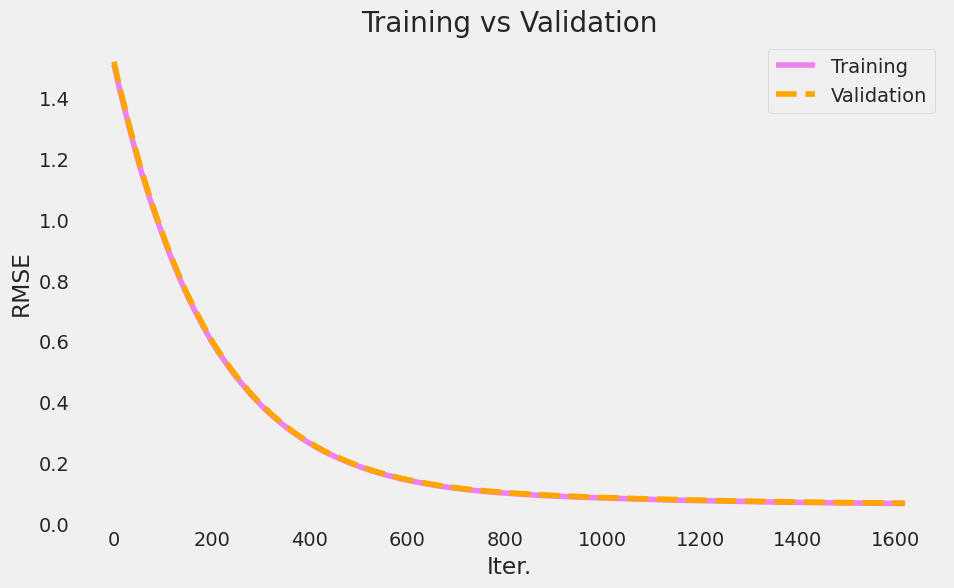

In [30]:
results = model.evals_result_
plt.figure(figsize=(10, 6))
plt.plot(results['training']['rmse'], label='Training', color='violet')
plt.plot(results['valid_1']['rmse'], label='Validation', color='orange', ls = "--")
plt.xlabel('Iter.')
plt.ylabel('RMSE')
plt.title('Training vs Validation')
plt.legend()
plt.grid()
plt.show()

                          Feature  Importance
21             product_codificado       11589
1                             gdp        8274
20               store_codificado        5855
15                      month_sin        3998
7                     day_of_week        3409
27        week_of_year_codificado        3146
25       month_product_codificado        2227
16                      month_cos        1323
6                             day        1188
23       month_country_codificado        1123
0                            year        1025
3               Unemployment Rate        1013
17                       year_sin         544
22               month_codificado         539
24         month_store_codificado         502
2   Final Consumption Expenditure         487
18                       year_cos         399
4                      Population         354
8                      is_weekend         346
5                             BOT         296
26             Quarter_codificado 

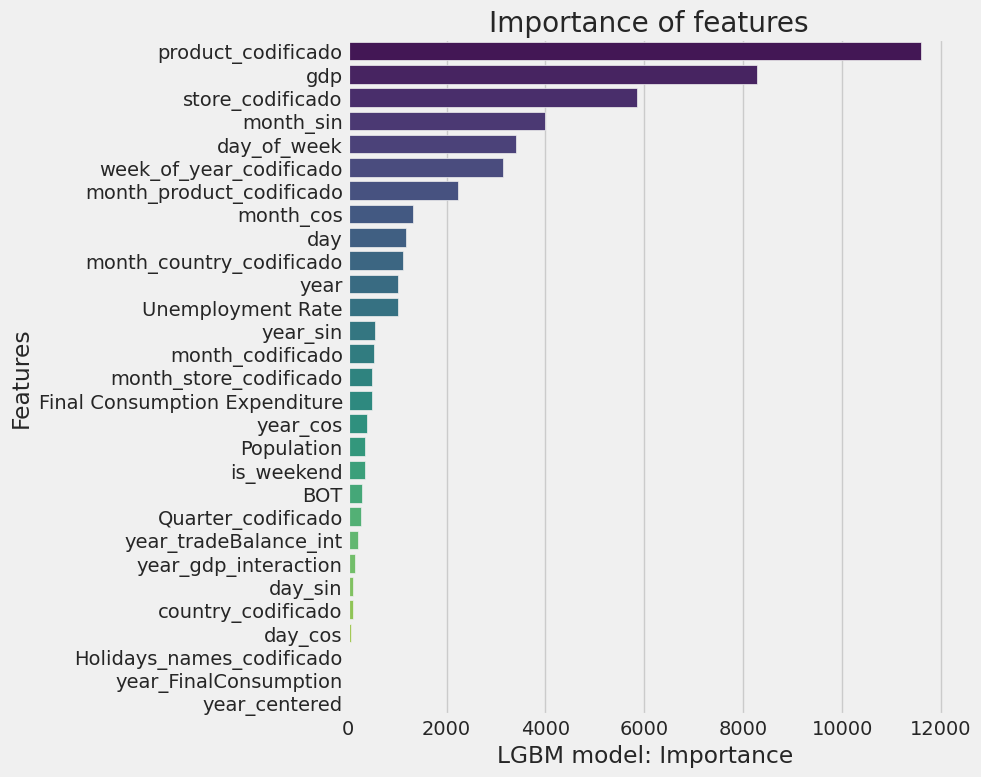

In [31]:
# Importance of features

importance = model.feature_importances_
features = X_train.columns


importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)


plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Importance of features')
plt.xlabel('LGBM model: Importance ')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


## ✅ Submission:

In [32]:
y_TEST_pred = model.predict(X_test, num_iteration=model.best_iteration_)
y_TEST_pred_reverted = np.expm1(y_TEST_pred)

In [33]:
# 98550 
submission = pd.DataFrame()
submission["id"] = X_test.index
submission["num_sold"] = y_TEST_pred_reverted
# submission.to_csv("submission.csv", index=False)
submission.to_csv('submission.csv', index=False)
submission

,id,num_sold
0,230130,141.650244
1,230131,863.817103
2,230132,722.231325
3,230133,383.435500
4,230134,473.935426
...,...,...
98545,328675,462.874073
98546,328676,2901.897851
98547,328677,2458.918534
98548,328678,1413.367381


## 💬 Expression of Gratitude

This is my first project in time series analysis, and I am deeply grateful for the wealth of techniques and insights I've learned from all of you, Kagglers. Your shared notebooks, discussions, and creative approaches have been an invaluable resource for my learning journey.

Through your generosity and dedication, I've not only improved my skills but also gained confidence in tackling more complex problems. Thank you for fostering such a supportive and inspiring community. I hope to contribute back and keep growing alongside you all!

In [34]:
full.to_csv("full_stickersales.csv")